# MILP vs GNN Benchmark Overview

Run the cells below to compare MILP baseline estimates with the selected GNN model. Update RUN_DIR if you want to analyse a different experiment.

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

def _locate_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        candidate = candidate.resolve()
        if (candidate / 'src').exists():
            return candidate
    raise RuntimeError('Could not locate project root containing "src" directory')

PROJECT_ROOT = _locate_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except ImportError:  # pragma: no cover
    sns = None
    plt.style.use('ggplot')

from src.analysis.performance import build_combined_performance

RUN_DIR = Path('outputs/gnn_runs/baseline')
SPLIT = 'test'
combined_df, summary = build_combined_performance(RUN_DIR, split=SPLIT, device='cpu')
if combined_df.empty:
    raise ValueError(f"No evaluation rows found for split '{SPLIT}'.")
display(pd.DataFrame([summary]))
display(combined_df[['scenario_id', 'milp_objective', 'gnn_cost_gap', 'gnn_violation_rate', 'gnn_speedup_est']])


,run_dir,split,checkpoint,scenarios,total_inference_seconds,mean_dispatch_mae,mean_cost_gap,mean_violation_rate,forward_pass_seconds,scenarios_with_milp,mean_milp_runtime_seconds,mean_speedup_est
0,outputs\gnn_runs\baseline,test,outputs\gnn_runs\baseline\best_model.pt,93,8.527207,9.690628,3.575107,0.464797,8.527207,93,2.770937,30.010913


,scenario_id,milp_objective,gnn_cost_gap,gnn_violation_rate,gnn_speedup_est
0,d8bda999-29c1-4716-81bf-b83a98c3a585,4.628215e+07,-0.187603,0.529356,21.587382
1,ff86cb97-dc55-49a8-a462-66a6ae2b6fd3,2.289353e+07,-0.250003,0.465278,15.177823
2,f4c00bb7-9ff7-4f41-bb42-7c85351133a7,5.159575e+07,-0.665813,0.411458,18.505664
3,53b21a76-d33a-4d29-a1b2-a91daa1baeb9,1.327031e+07,3.277963,0.592949,23.099990
4,ce2e2bba-8aec-4249-9a4b-87fd3cf1ec9d,7.961896e+07,-0.570652,0.454657,27.054019
...,...,...,...,...,...
88,f20f1f0b-0b15-4a49-8270-52f238908e99,4.504387e+07,-0.454680,0.529018,21.549416
89,bb50e446-fb29-4e8a-84f7-b3f747df8779,5.874323e+07,-0.823623,0.412760,17.730934
90,7ab42391-37c4-46ef-929e-0830b1d3eb7d,4.208675e+07,-0.152495,0.399038,24.441850
91,63ccca29-cf52-435e-b79b-1ee7d2d7ac71,1.044298e+08,-0.278959,0.469271,34.832122


## Cost Gap by Scenario

Relative cost gap compares the weighted dispatch cost produced by the GNN to the MILP objective (0 indicates parity).

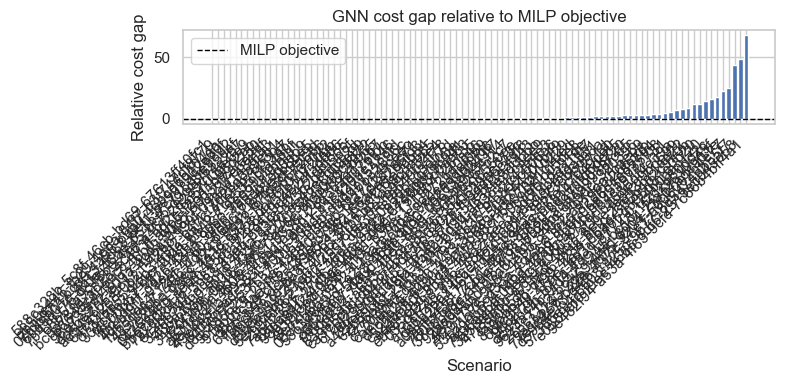

In [3]:
sorted_df = combined_df.sort_values('gnn_cost_gap').reset_index(drop=True)
labels = sorted_df['scenario_id'].astype(str)
x = range(len(sorted_df))
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x, sorted_df['gnn_cost_gap'], color='#4c72b0')
ax.axhline(0, color='black', linestyle='--', linewidth=1, label='MILP objective')
ax.set_xticks(list(x))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Relative cost gap')
ax.set_xlabel('Scenario')
ax.set_title('GNN cost gap relative to MILP objective')
ax.legend()
plt.tight_layout()


## Feasibility / Violation Rate

Constraint violation rate corresponds to the share of node-time points with unmet demand (after decoder corrections).

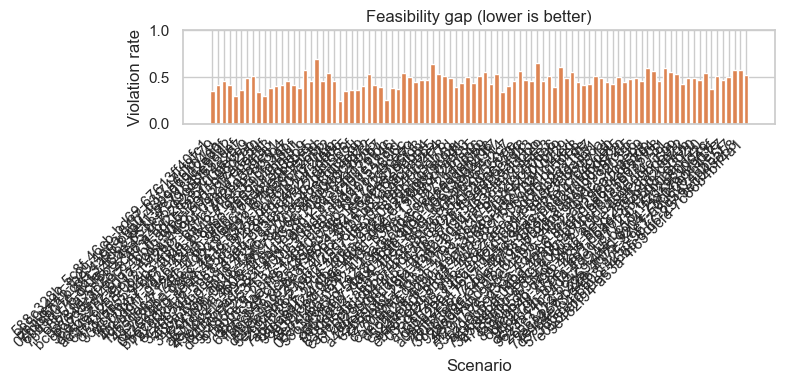

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x, sorted_df['gnn_violation_rate'], color='#dd8452')
ax.set_xticks(list(x))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Violation rate')
ax.set_xlabel('Scenario')
ax.set_ylim(0, 1)
ax.set_title('Feasibility gap (lower is better)')
plt.tight_layout()


## Estimated Speed-up

MILP runtime uses the estimated CPU hours field from the scenario metadata, while GNN time comes from measured inference wall-clock.

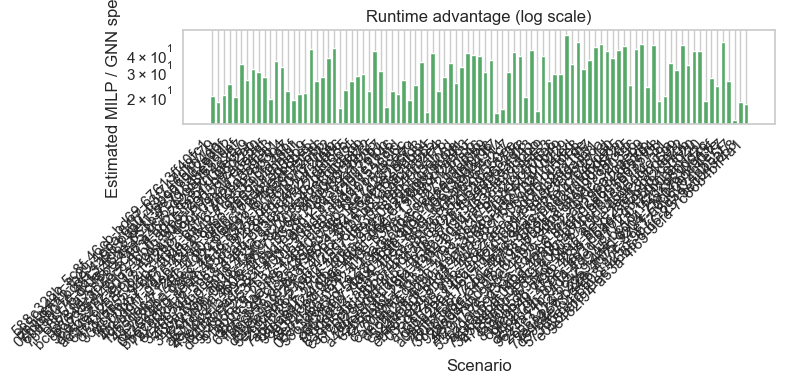

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
speedups = sorted_df['gnn_speedup_est']
ax.bar(x, speedups, color='#55a868')
ax.set_xticks(list(x))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yscale('log')
ax.set_ylabel('Estimated MILP / GNN speed-up')
ax.set_xlabel('Scenario')
ax.set_title('Runtime advantage (log scale)')
plt.tight_layout()


## Cost Gap vs Feasibility Scatter

Use the scatter plot to see whether cost accuracy trades off with feasibility.

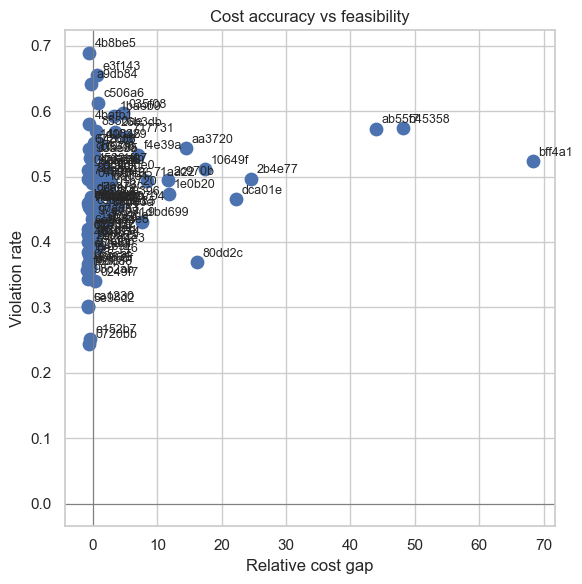

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(combined_df['gnn_cost_gap'], combined_df['gnn_violation_rate'], s=80, color='#4c72b0')
for _, row in combined_df.iterrows():
    ax.annotate(row['scenario_id'][-6:], (row['gnn_cost_gap'], row['gnn_violation_rate']),
                textcoords='offset points', xytext=(4, 4), fontsize=9)
ax.axhline(0, color='grey', linewidth=0.8)
ax.axvline(0, color='grey', linewidth=0.8)
ax.set_xlabel('Relative cost gap')
ax.set_ylabel('Violation rate')
ax.set_title('Cost accuracy vs feasibility')
plt.tight_layout()
